# Prévision de churn d'assurance habitation
Février 2022 - Geoffroy Leboucher

## Objectif
L'objectif est de de prédire si un client compte résilier ou non son contrat d’assurance habitation
en fonction de différentes caractéristiques. <br/><br/>
Une attention plus forte sera donnée à bien prédire les clients qui vont résilier. </br>
En d'autre terme on préfère avoir des faux-positifs que des faux-négatifs </br>
Pour le dire encore autrement on veut favoriser le **recall** à la **précision**

## Import des librairies

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import os

%matplotlib inline

## Récupération les données


In [2]:
dates_columns = ['debut_contrat', 'ouverture_dernier_sinistre', 'cloture_dernier_sinistre']
data_train = pd.read_csv("data/Input pour construction modele.csv",
                         parse_dates=dates_columns,
                         index_col="index")
data_test = pd.read_csv("data/Input pour application modele.csv",
                        parse_dates=dates_columns,
                        index_col="index")

print(data_test.shape)
print(data_train.shape)

(300, 13)
(1000, 14)


In [3]:
data_train.head()

,age,departement,categorie_socio_professionnelle,type_de_bien,statut,surface,montant_assure,debut_contrat,nb_sinistres_depuis_ouverture,ouverture_dernier_sinistre,cloture_dernier_sinistre,cotisation_n-1,cotisation_n,target
index,,,,,,,,,,,,,,
0,46.0,92,"Artisans, commerçants, chefs d'entreprise",Appartement,Occupant à titre gratuit,65.30,15074.0,1996-02-04,2.0,1999-06-23 18:33:38,1999-08-16 18:33:38,222.22,235.18,0
1,30.0,93,Employés,Appartement,Propriétaire,61.96,29868.0,1997-12-15,1.0,1999-03-29 18:54:35,1999-04-28 18:54:35,191.55,193.06,0
2,26.0,70,"Artisans, commerçants, chefs d'entreprise",Maison,Locataire,121.87,23310.0,2007-12-03,2.0,2008-09-10 11:50:29,2009-01-21 11:50:29,376.53,376.53,0
3,37.0,86,Employés,Maison,Propriétaire,73.85,16432.0,2014-02-16,1.0,2017-07-31 13:42:48,2017-09-25 13:42:48,364.31,394.98,1
4,29.0,18,Cadres et professions intellectuelles supérieures,Appartement,Locataire,64.34,15943.0,1995-02-17,2.0,1998-07-27 12:39:12,1998-10-28 12:39:12,232.28,245.56,0


In [4]:
data_train.describe(include='all', percentiles=[], datetime_is_numeric=True)

,age,departement,categorie_socio_professionnelle,type_de_bien,statut,surface,montant_assure,debut_contrat,nb_sinistres_depuis_ouverture,ouverture_dernier_sinistre,cloture_dernier_sinistre,cotisation_n-1,cotisation_n,target
count,1000.000000,1000,1000,1000,1000,1000.000000,1000.000000,1000,1000.000000,850,850,1000.000000,1000.000000,1000.000000
unique,NaN,101,6,2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,94,Employés,Appartement,Locataire,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,60,341,634,586,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,42.198000,NaN,NaN,NaN,NaN,86.863400,22461.069000,2007-09-30 07:06:14.400000512,1.492000,2009-11-22 02:26:24.577648128,2010-01-08 04:26:54.224705280,272.762170,286.046570,0.170000
min,15.000000,NaN,NaN,NaN,NaN,31.270000,4478.000000,1995-01-14 00:00:00,0.000000,1995-04-19 10:00:16,1995-04-20 10:00:16,175.380000,181.360000,0.000000
50%,42.000000,NaN,NaN,NaN,NaN,80.605000,21201.000000,2007-12-04 00:00:00,1.000000,2010-02-11 23:23:54.500000,2010-04-11 08:48:03.500000,227.525000,240.705000,0.000000
max,94.000000,NaN,NaN,NaN,NaN,179.780000,55852.000000,2020-12-25 00:00:00,4.000000,2020-12-27 12:55:57,2020-12-30 21:07:36,440.870000,510.490000,1.000000
std,14.710853,NaN,NaN,NaN,NaN,28.498626,9076.273609,NaN,0.954383,NaN,NaN,76.378759,82.097481,0.375821


## Commentaires sur les features
#### age
Mean 42 ans / no missing values / Feature interessant à garder tel quel

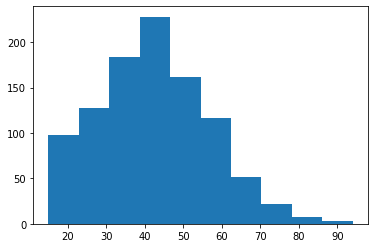

In [5]:
plt.hist(data_train['age'])
plt.show()

#### departement
Top 94 / no missing values / Feature intéressant mais peut-etre un peu large -> région ?

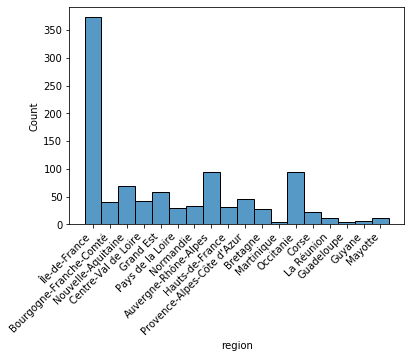

In [6]:
from data.transco_regions import DEPARTMENTS
data_train['region'] = data_train['departement'].map(DEPARTMENTS)
data_test['region'] = data_test['departement'].map(DEPARTMENTS)
sns.histplot(data_train, x='region')
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

#### categorie_socio_professionnelle
6 valeurs uniques / no missing values / Feature intéressant à garder tel quel ou regrouper si possible
#### type_de_bien
2 valeurs uniques ('Maison' ou 'Appartement') / no missing values / Feature intéressant à garder tel quel (+passer en Bool)

In [7]:
data_train['is_house'] = data_train['type_de_bien'] == 'Maison'
data_test['is_house'] = data_test['type_de_bien'] == 'Maison'

#### statut
3 valeurs uniques / no missing values / Feature intéressant à garder tel quel
#### surface
Mean 86m2 / no missing values / Feature intéressant à garder tel quel

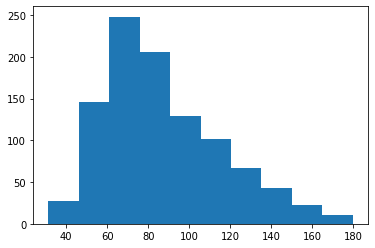

In [8]:
plt.hist(data_train['surface'])
plt.show()

#### montant_assure
no missing values / Feature intéressant à garder tel quel

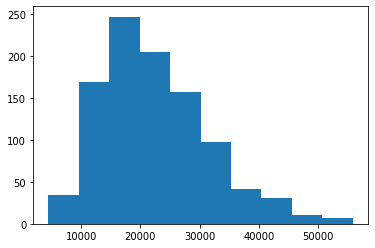

In [9]:
plt.hist(data_train['montant_assure'])
plt.show()

#### debut_contrat
no missing values / Feature intéressant à garder tel quel

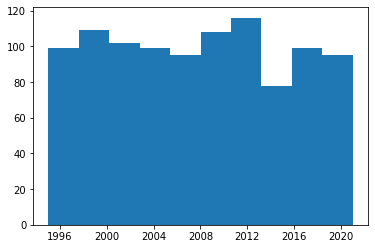

In [10]:
plt.hist(data_train['debut_contrat'])
plt.show()

#### nb_sinistres_depuis_ouverture
Mean 1.5 / no missing values / Feature intéressant à garder tel quel
#### ouverture_dernier_sinistre
150 clients sans sinistre/ Tous les sinistres sont clos / Feature peu intéressant seul / à combiner avec cloture_dernier_sinistre

In [11]:
print("Nombre de sinistre non-clos: ",
      data_train.loc[~data_train['ouverture_dernier_sinistre'].isna(), 'cloture_dernier_sinistre'].isna().sum())

Nombre de sinistre non-clos:  0


#### cloture_dernier_sinistre
150 clients sans sinistre/ Tous les sinistres sont clos / Feature peu intéressant seul / à combiner avec ouverture_dernier_sinistre
#### cotisation_n-1
Mean 273 / no missing values / Feature intéressant à combiner avec cotisation_n / On observe deux répartitions de prix -> deux contrats différents?

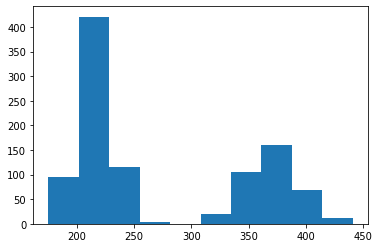

In [12]:
plt.hist(data_train['cotisation_n-1'])
plt.show()

data_train['contract_low'] = data_train['cotisation_n-1'] < 300
data_test['contract_low'] = data_test['cotisation_n-1'] < 300

#### cotisation_n
Mean 286 / no missing values / Feature intéressant à combiner avec cotisation_n-1

#### target
Seulement 170 churn / Dataset déséquilibré

## Feature Engineering
#### cotisation_increase
Création d'un feature donnant l'évolution de la cotisation depuis la dernière année(?)

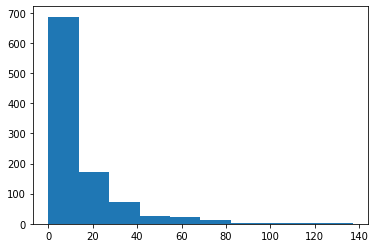

In [13]:
data_train['cotisation_increase'] = data_train['cotisation_n'] - data_train['cotisation_n-1']
data_test['cotisation_increase'] = data_test['cotisation_n'] - data_test['cotisation_n-1']
plt.hist(data_train['cotisation_increase'])
plt.show()

#### duree_dernier_sinistre
Création d'un feature donnant la durée du dernier sinistre

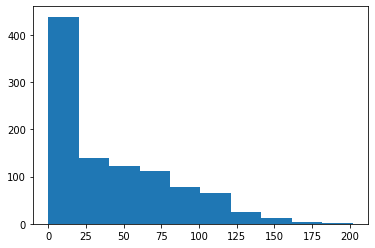

In [14]:
data_train['duree_dernier_sinistre'] = (data_train['cloture_dernier_sinistre']
                                        - data_train['ouverture_dernier_sinistre']
                                        ).dt.days.fillna(0)
data_test['duree_dernier_sinistre'] = (data_test['cloture_dernier_sinistre']
                                       - data_test['ouverture_dernier_sinistre']
                                       ).dt.days.fillna(0)

plt.hist(data_train['duree_dernier_sinistre'])
plt.show()

### Data Analysis

#### Dates de contrat vs dernier sinistre

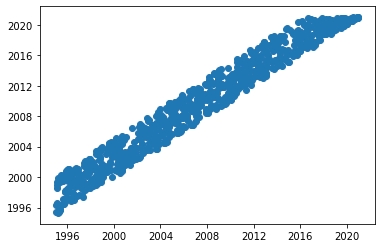

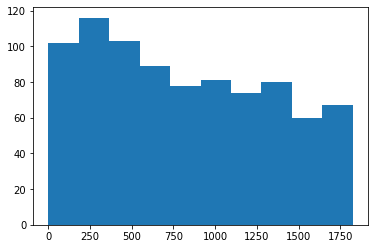

Durée des contrats : 5.0 ans


In [15]:
plt.scatter(x=data_train["debut_contrat"], y=data_train['ouverture_dernier_sinistre'])
plt.show()
plt.hist(x=(data_train["ouverture_dernier_sinistre"] -data_train['debut_contrat']).dt.days)
plt.show()
print("Durée des contrats : {} ans".format(
    round(max((data_train["ouverture_dernier_sinistre"] - data_train['debut_contrat']).dt.days)/365, 2)))

J'en conclus que les contrats sont signés pour 5 ans. </br>
Je crée un feature remaining days = nombre de jours restant entre dernier sinistre et fin du contrat. En effet,
je pense qu'on a moins de chance de résilier lorsque le contrat arrive bientôt à sa fin.

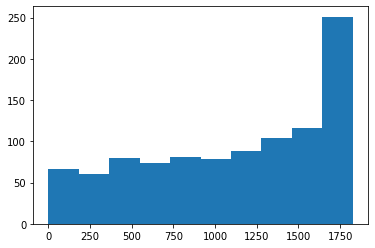

In [16]:
data_train['remaining_days'] = 5*365.25 - (data_train["ouverture_dernier_sinistre"]
                                           - data_train['debut_contrat']).dt.days.fillna(0)
data_test['remaining_days'] = 5*365.25 - (data_test["ouverture_dernier_sinistre"]
                                           - data_test['debut_contrat']).dt.days.fillna(0)
plt.hist(x=data_train["remaining_days"])
plt.show()

### Tracé des features les un par raport aux autres

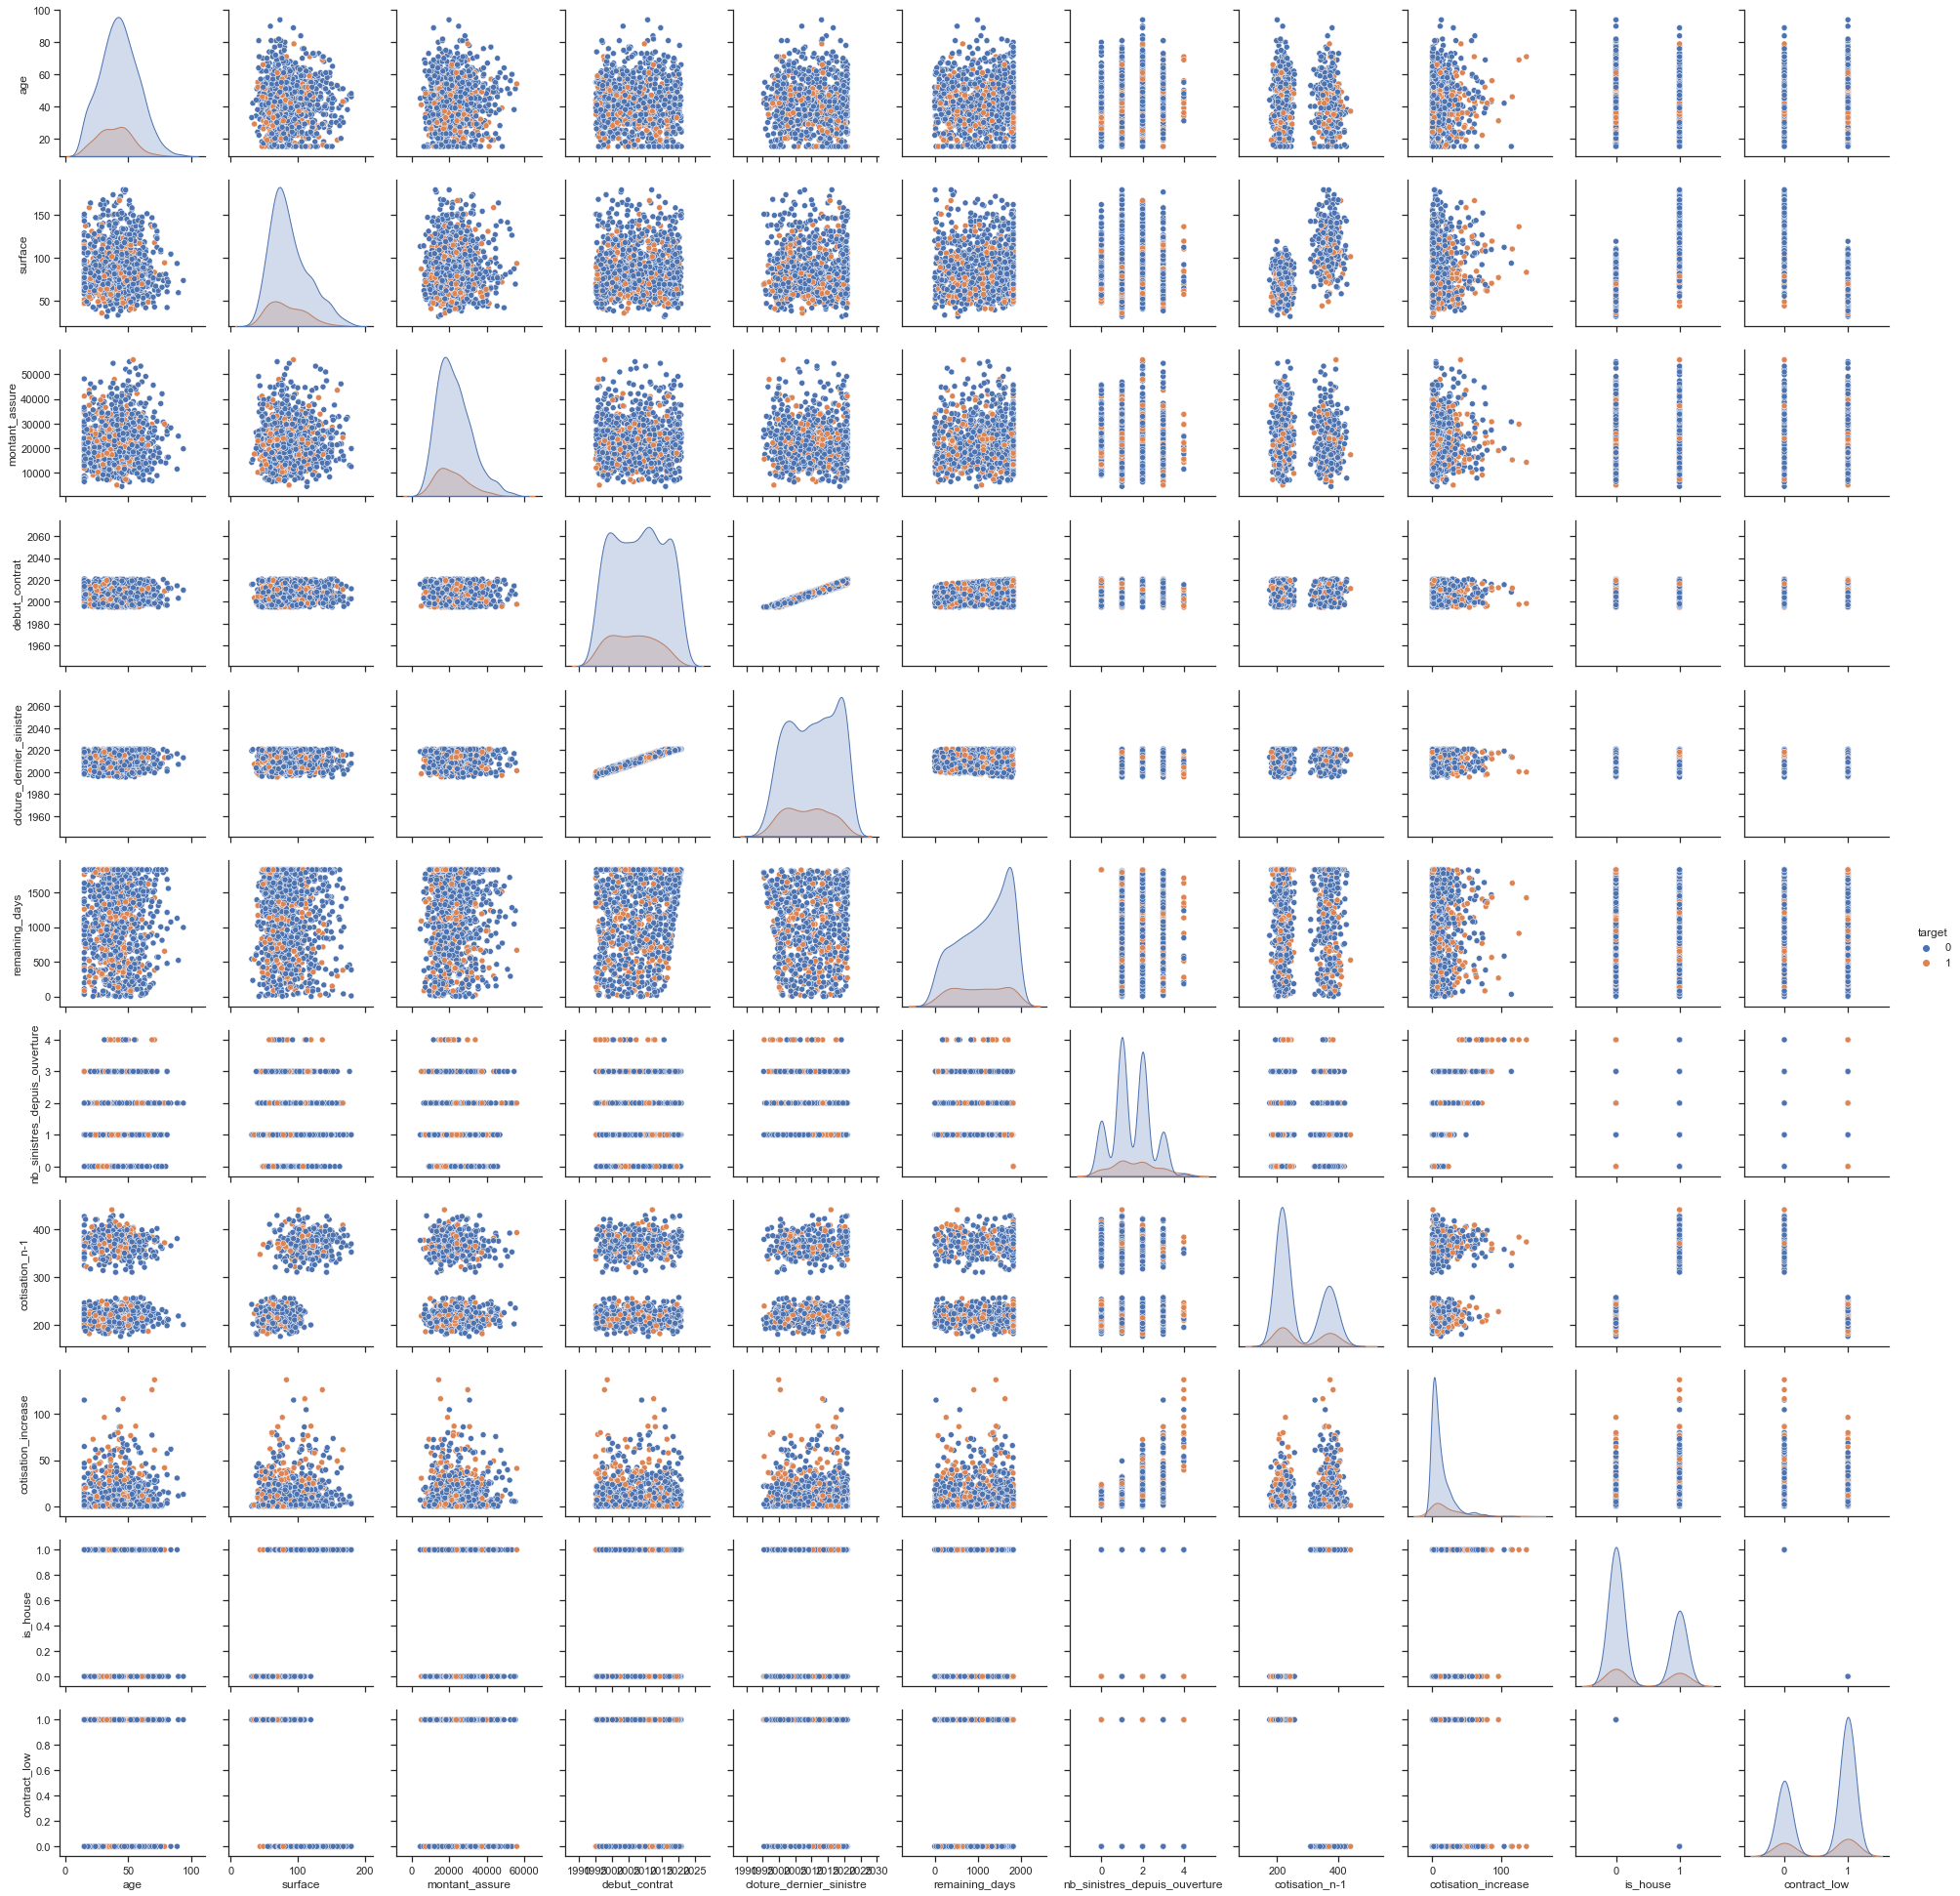

In [17]:
studied_columns = ['age', 'surface', 'montant_assure', 'debut_contrat', 'cloture_dernier_sinistre', 'remaining_days',
                  'nb_sinistres_depuis_ouverture', 'cotisation_n-1', 'cotisation_increase', 'is_house', 'contract_low'] # 'departement'

#Correlation
sns.set(style="ticks")
sns.pairplot(data_train,
    vars=studied_columns,
             hue='target')
plt.show()

On peut tirer quelques infos du graph :
* Les contrats sont différents si une maison ou appartement ('is_house' vs 'contract_low') -> 'contract_low ' inutile
* Les augmentations de cotisations sont corrélées au nombre de sinistres
* La proportion de churn est plus importante lorsque le nombre de sinistres ou l'augmentation est élevée
* Contre-intuitivement les clotures ont plutôt lieux en fin de contrat

### %churn par catégorie :

is_house


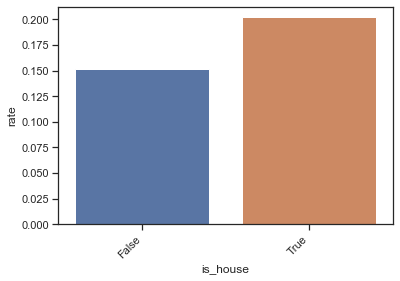

   is_house  nb_churn  nb_total      rate
0     False        96       634  0.151420
1      True        74       366  0.202186
region


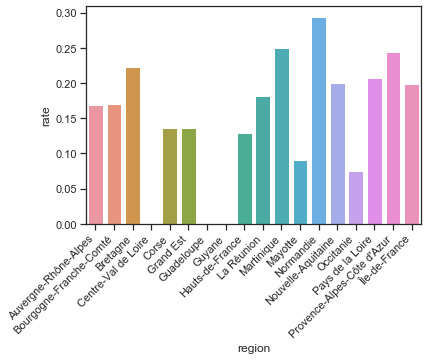

                        region  nb_churn  nb_total      rate
0         Auvergne-Rhône-Alpes        16        95  0.168421
1      Bourgogne-Franche-Comté         7        41  0.170732
2                     Bretagne         6        27  0.222222
3          Centre-Val de Loire         0        42  0.000000
4                        Corse         3        22  0.136364
5                    Grand Est         8        59  0.135593
6                   Guadeloupe         0         5  0.000000
7                       Guyane         0         7  0.000000
8              Hauts-de-France         4        31  0.129032
9                   La Réunion         2        11  0.181818
10                  Martinique         1         4  0.250000
11                     Mayotte         1        11  0.090909
12                   Normandie        10        34  0.294118
13          Nouvelle-Aquitaine        14        70  0.200000
14                   Occitanie         7        94  0.074468
15            Pays de la

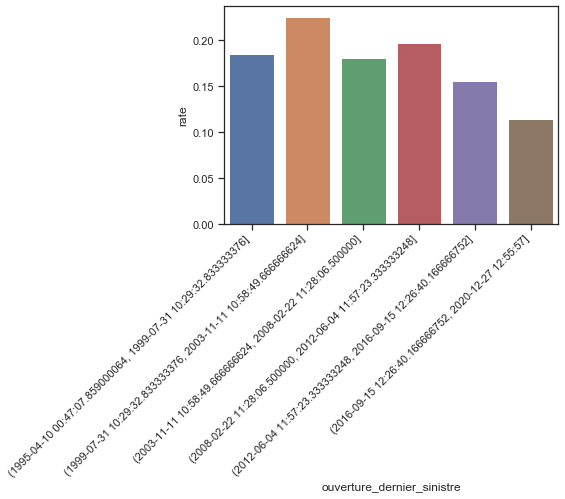

                          ouverture_dernier_sinistre  nb_churn  nb_total  \
0  (1995-04-10 00:47:07.859000064, 1999-07-31 10:...        13        70   
1  (1999-07-31 10:29:32.833333376, 2003-11-11 10:...        35       155   
2  (2003-11-11 10:58:49.666666624, 2008-02-22 11:...        24       133   
3  (2008-02-22 11:28:06.500000, 2012-06-04 11:57:...        28       142   
4  (2012-06-04 11:57:23.333333248, 2016-09-15 12:...        23       148   
5  (2016-09-15 12:26:40.166666752, 2020-12-27 12:...        23       202   

       rate  
0  0.185714  
1  0.225806  
2  0.180451  
3  0.197183  
4  0.155405  
5  0.113861  
surface


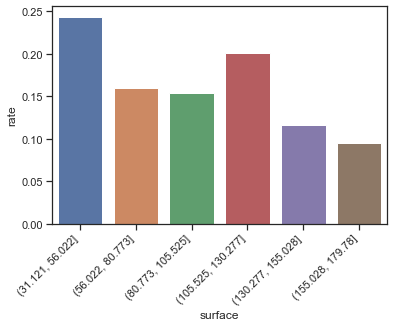

              surface  nb_churn  nb_total      rate
0    (31.121, 56.022]        28       115  0.243478
1    (56.022, 80.773]        62       388  0.159794
2   (80.773, 105.525]        39       253  0.154150
3  (105.525, 130.277]        31       154  0.201299
4  (130.277, 155.028]         8        69  0.115942
5   (155.028, 179.78]         2        21  0.095238
debut_contrat


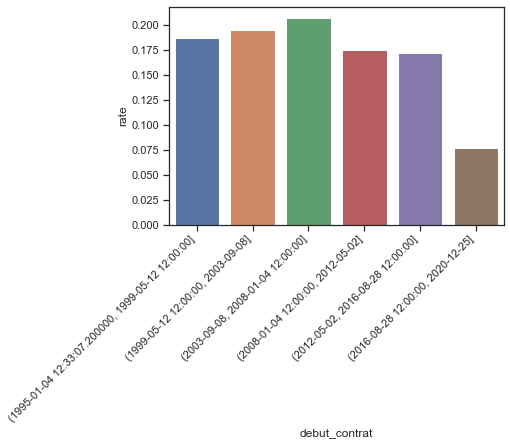

                                       debut_contrat  nb_churn  nb_total  \
0  (1995-01-04 12:33:07.200000, 1999-05-12 12:00:00]        33       176   
1                  (1999-05-12 12:00:00, 2003-09-08]        33       169   
2                  (2003-09-08, 2008-01-04 12:00:00]        33       159   
3                  (2008-01-04 12:00:00, 2012-05-02]        32       183   
4                  (2012-05-02, 2016-08-28 12:00:00]        27       157   
5                  (2016-08-28 12:00:00, 2020-12-25]        12       156   

       rate  
0  0.187500  
1  0.195266  
2  0.207547  
3  0.174863  
4  0.171975  
5  0.076923  
categorie_socio_professionnelle


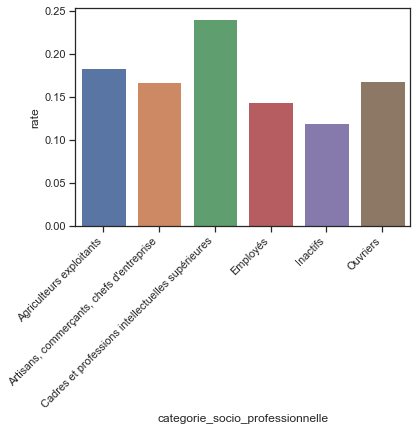

                     categorie_socio_professionnelle  nb_churn  nb_total  \
0                           Agriculteurs exploitants        24       131   
1          Artisans, commerçants, chefs d'entreprise        29       174   
2  Cadres et professions intellectuelles supérieures        39       162   
3                                           Employés        49       341   
4                                           Inactifs         8        67   
5                                           Ouvriers        21       125   

       rate  
0  0.183206  
1  0.166667  
2  0.240741  
3  0.143695  
4  0.119403  
5  0.168000  
cotisation_n-1


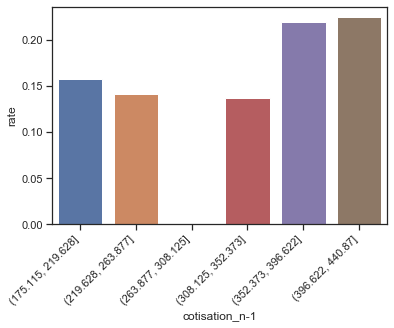

       cotisation_n-1  nb_churn  nb_total      rate
0  (175.115, 219.628]        61       386  0.158031
1  (219.628, 263.877]        35       248  0.141129
2  (263.877, 308.125]         0         0       NaN
3  (308.125, 352.373]        11        80  0.137500
4  (352.373, 396.622]        52       237  0.219409
5   (396.622, 440.87]        11        49  0.224490
cotisation_increase


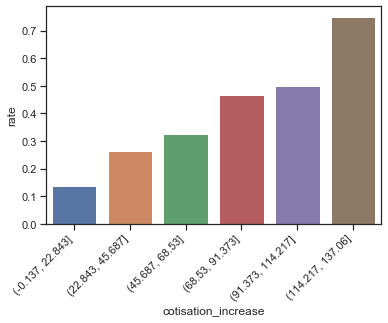

  cotisation_increase  nb_churn  nb_total      rate
0    (-0.137, 22.843]       113       814  0.138821
1    (22.843, 45.687]        34       128  0.265625
2     (45.687, 68.53]        12        37  0.324324
3     (68.53, 91.373]         7        15  0.466667
4   (91.373, 114.217]         1         2  0.500000
5   (114.217, 137.06]         3         4  0.750000
montant_assure


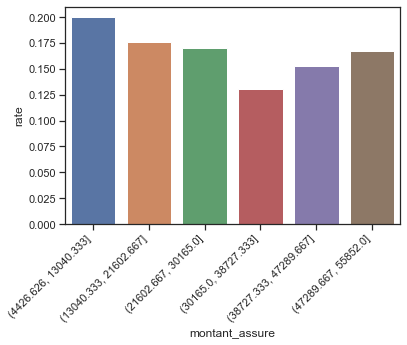

           montant_assure  nb_churn  nb_total      rate
0   (4426.626, 13040.333]        26       130  0.200000
1  (13040.333, 21602.667]        69       393  0.175573
2    (21602.667, 30165.0]        49       289  0.169550
3    (30165.0, 38727.333]        17       130  0.130769
4  (38727.333, 47289.667]         7        46  0.152174
5    (47289.667, 55852.0]         2        12  0.166667
remaining_days


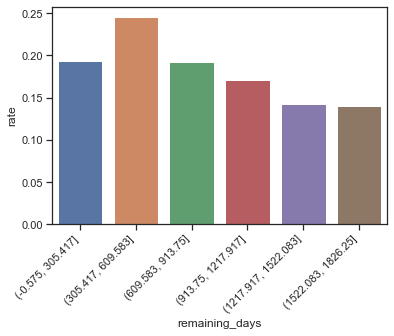

         remaining_days  nb_churn  nb_total      rate
0     (-0.575, 305.417]        22       114  0.192982
1    (305.417, 609.583]        29       118  0.245763
2     (609.583, 913.75]        25       130  0.192308
3    (913.75, 1217.917]        24       140  0.171429
4  (1217.917, 1522.083]        24       169  0.142012
5   (1522.083, 1826.25]        46       329  0.139818
statut


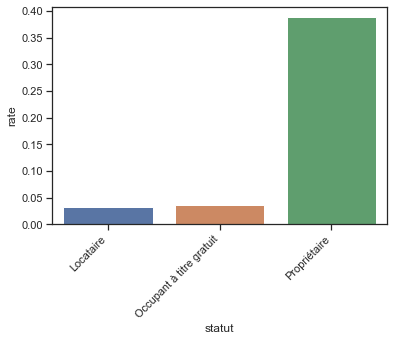

                     statut  nb_churn  nb_total      rate
0                 Locataire        19       586  0.032423
1  Occupant à titre gratuit         1        28  0.035714
2              Propriétaire       150       386  0.388601
age


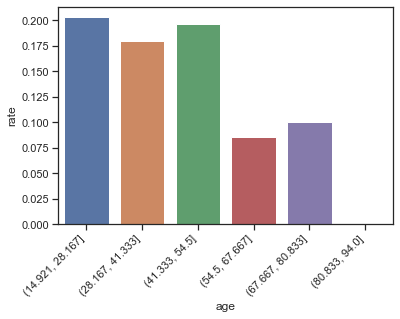

                age  nb_churn  nb_total      rate
0  (14.921, 28.167]        37       182  0.203297
1  (28.167, 41.333]        56       312  0.179487
2    (41.333, 54.5]        60       305  0.196721
3    (54.5, 67.667]        13       152  0.085526
4  (67.667, 80.833]         4        40  0.100000
5    (80.833, 94.0]         0         9  0.000000
nb_sinistres_depuis_ouverture


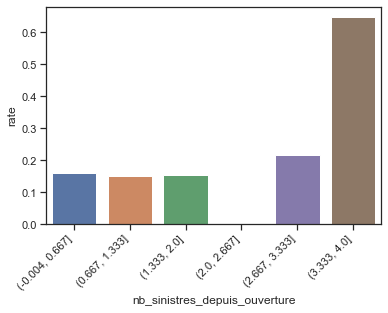

  nb_sinistres_depuis_ouverture  nb_churn  nb_total      rate
0               (-0.004, 0.667]        24       150  0.160000
1                (0.667, 1.333]        56       371  0.150943
2                  (1.333, 2.0]        51       333  0.153153
3                  (2.0, 2.667]         0         0       NaN
4                (2.667, 3.333]        28       129  0.217054
5                  (3.333, 4.0]        11        17  0.647059


In [18]:
bins_size = 6
cat_features = ['categorie_socio_professionnelle', 'statut', 'debut_contrat', 'region',
                'nb_sinistres_depuis_ouverture', 'is_house'] # 'departement',
num_features = ['age', 'surface', 'montant_assure', 'debut_contrat', 'ouverture_dernier_sinistre', 'remaining_days',
                'nb_sinistres_depuis_ouverture', 'cotisation_n-1', 'cotisation_increase']

for feature in set(cat_features + num_features) :
    print(feature)
    if feature in num_features:
        cuts = pd.cut(data_train[feature], bins_size)
    else:
        cuts = feature
    groups = data_train.groupby(cuts).agg(nb_churn=('target', 'sum'), nb_total=('target', 'count')).reset_index()
    groups['rate'] = groups['nb_churn'] / groups['nb_total']
    ax = sns.barplot(x=feature, y="rate", data=groups)
    plt.xticks(rotation=45, horizontalalignment='right')
    plt.show()
    print(groups)

**Main take away** </br>
cotisation_increase : si augmentation > 25€ alors %churn > 35% </br>
nb_sinistres_depuis_ouverture : si 4 sinistre alors %churn > 60% </br>
status : Si non proprio %churn < 5%



## Data Preparation
Avant de commencer la mdelisation, il reste encore quelques modifications à apporter à notre dataset

### Élagage des Features

In [19]:
# Retrait de :
# 'cloture_dernier_sinistre', 'ouverture_dernier_sinistre' car n'apport rien une fois que l'on a
#   - la durée du dernier sinistre
#   - le remaining time
#   - le début de contrat
# Département est trop large pour pouvoir être traité efficacement (trop peu de records)
# Région pourra être exploité dans un second temps (regrouper les régions). A voir si le temps le permet
# cotisation_n redondant avec cotisation_n-1 et cotisation_increase
# contract_low, type_de_bien redondants avec is_house

excluded_features = ["target", 'contract_low', 'cotisation_n', 'cloture_dernier_sinistre',
                     'ouverture_dernier_sinistre', 'departement', 'region', 'type_de_bien']
X_train = data_train.drop(columns=excluded_features)
X_test = data_test.drop(columns=excluded_features, errors="ignore")
y_train = data_train[["target"]].values.ravel()

# Convertion des dates en integer
X_train['debut_contrat'] = (X_train['debut_contrat']- pd.to_datetime('1970-01-01')).dt.total_seconds()/1000
X_test['debut_contrat'] = (X_test['debut_contrat']- pd.to_datetime('1970-01-01')).dt.total_seconds()/1000

### Categorical features -> Numerical
#### One-Hot Encoding
On choisit de faire du One Hot Encoding sur statut et categorie_socio_professionnelle (discutable : regroupement ou ordonnancement)

In [20]:
from sklearn.preprocessing import OneHotEncoder
# X_train[['statut', 'categorie_socio_professionnelle']]

# OneHotEncoder.fit_transform(X_train[['statut', 'categorie_socio_professionnelle']]).toarray()
OHE = OneHotEncoder(handle_unknown="ignore").fit(X_train[['statut', 'categorie_socio_professionnelle']])
enc_train = pd.DataFrame(OHE
                         .transform(X_train[['statut', 'categorie_socio_professionnelle']])
                         .toarray(), index=X_train.index)
enc_test = pd.DataFrame(OHE
                        .transform(X_test[['statut', 'categorie_socio_professionnelle']])
                        .toarray(), index=X_test.index)
enc_train.columns = OHE.get_feature_names()
enc_test.columns = OHE.get_feature_names()
X_train = X_train.drop(columns=['statut', 'categorie_socio_professionnelle']).join(enc_train)
X_test = X_test.drop(columns=['statut', 'categorie_socio_professionnelle']).join(enc_test)


C:\Users\s607877\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Normalization
Centrage réduction

In [21]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)


### matrice de correlation

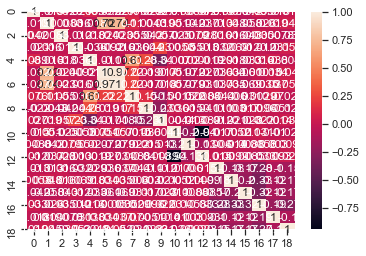

In [22]:
# Correlation
import seaborn as sn
corrMatrix = np.corrcoef(X_train.T)
sn.heatmap(corrMatrix, annot=True)
plt.show()

## Modelization
### Note
En raison du faible nombre d'échantillon nous allons utiliser une cross-validation afin de s'assurer
que l'on ne fait pas de sur-apprentissage.

### Definition d'une baseline

In [23]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
dummy_regr = DummyClassifier(strategy="constant", constant=1)
cross_val_score(dummy_regr, X_train, y_train, cv=5, scoring="f1").mean()

0.2905982905982906

Un peu simpliste... Peut mieux faire

In [24]:
from sklearn.model_selection import cross_val_score
class VanillaClassifier :
    def __init__(self) :
        pass

    def fit(self, X, y) :
        pass

    def get_params(self, deep=True) :
        return {}

    def predict(self, X) :
        # Simple condition: 1 si propriétaire, 0 sinon
        return (X["x0_Propriétaire"]>0).astype(int).to_list()


cross_val_score(VanillaClassifier(), X_train, y_train, cv=5,
                scoring = 'f1').mean()

0.5344000920040146

Partons sur un score f1 baseline à 53%. Regardons comment on peut faire mieux.

### Regression Logisique
Premier modèle : regression logistique. Choix logique car forte explicabilité des résultats.

In [25]:
from sklearn.linear_model import LogisticRegression
cv = cross_val_score(LogisticRegression(), X_train, y_train, cv=5, scoring="f1")
print('LogisticRegression', cv.mean(), cv.std())

# from statsmodels.discrete.discrete_model import Logit
# from statsmodels.tools.tools import add_constant
# X_stat = add_constant(X_train)
# # on ajuste le modèle
# model = Logit(y_train, X_stat)
# result = model.fit()
# print(result.summary())

LogisticRegression 0.6231996722881523 0.060486865488528045


Un score à 62% c'est un beau progrès.

L'avantage de la regression logistique c'es que l'on peut façilement remonter à l'influence des features.

In [26]:
model = LogisticRegression().fit(X_train, y_train)
result = pd.DataFrame(np.concatenate([model.intercept_.reshape(-1,1),
                                      model.coef_],axis=1),
                      index = ["coef"],
                      columns = ["constante"]+list(X_train.columns)).T
print(result)

                                                        coef
constante                                          -2.827233
age                                                -0.467613
surface                                            -0.714992
montant_assure                                     -0.228661
debut_contrat                                      -0.349210
nb_sinistres_depuis_ouverture                      -0.348539
cotisation_n-1                                      0.539920
is_house                                            0.055664
cotisation_increase                                 0.862045
duree_dernier_sinistre                              0.526445
remaining_days                                     -0.053974
x0_Locataire                                       -0.875868
x0_Occupant à titre gratuit                        -0.196318
x0_Propriétaire                                     0.952682
x1_Agriculteurs exploitants                         0.017049
x1_Artisans, commerçants

Regardons la matrice de confusion et le recall :

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, cross_val_predict
def evaluate_model(model, X, y):
    result = cross_validate(model, X, y, cv=5, scoring=["f1", "recall", "precision"])
    preds = cross_val_predict(model, X, y, cv=5)
    matrix = pd.crosstab(y_train, preds,
                         rownames=['Réalité'], colnames=['Prédiction'])
    print("f1", np.mean(result['test_f1']), np.std(result['test_f1']))
    print("recall", np.mean(result['test_recall']), np.std(result['test_recall']))
    print("precision", np.mean(result['test_precision']), np.std(result['test_precision']))
    return matrix
model = LogisticRegression(random_state=42)
evaluate_model(model, X_train, y_train)

f1 0.6231996722881523 0.060486865488528045
recall 0.5235294117647059 0.05703152773430976
precision 0.7834506556245687 0.12372150195578167


Prédiction,0,1
Réalité,,
0,803,27
1,81,89


On observe un déséquilibre entre faux-positif et faux négatifs en raison du déséquilibre du dataset. </br>
Or, comme dit dans l'objectif, c'est un fort Recall que l'on cherche à avoir. Pour cela on va donc équilibrer le dataset.

### Equilibrage

In [28]:
# evaluate pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
steps = [('over', SMOTE()), ('model', LogisticRegression())]
pipeline = Pipeline(steps=steps)
evaluate_model(pipeline, X_train, y_train)


f1 0.628753364698172 0.0393798147971197
recall 0.8705882352941176 0.06056253024110002
precision 0.49285989407799713 0.03457946743760346


Prédiction,0,1
Réalité,,
0,678,152
1,23,147


Le score F1 n'a pas beaucoup changé, mais le recall s'est sensiblement amélioré. </br>
Point d'attention concernant les regression logistiques :
- Les influences sont considérées linéaires...
- Forte capacité à overfitter
- Sensible aux correlations -> Retirer les features avec une forte correlation si le temps le permet

## Random Forest
Essayons maintenant un modèle moins explicable mais généralement plus performant : les randomForest

In [29]:
# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

steps = [('over', SMOTE()), ('model', RandomForestClassifier())]
pipeline = Pipeline(steps=steps)
evaluate_model(pipeline, X_train, y_train)


f1 0.6506338002804017 0.0729108163850235
recall 0.6882352941176471 0.057635052771368905
precision 0.6190949175167253 0.0906222908334178


Prédiction,0,1
Réalité,,
0,762,68
1,58,112


On observe que le score F1 est meilleur mais qu'on a dégradé notre recall... </br>
Essayons de retirer des variables inutiles

In [30]:
# feature importance
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier().fit(X_train, y_train)
for c, i in zip(X_train.columns, model.feature_importances_):
    print(c,i)

age 0.08467493721441174
surface 0.08975349885405016
montant_assure 0.07518445173678753
debut_contrat 0.08939408778829079
nb_sinistres_depuis_ouverture 0.03269500705816127
cotisation_n-1 0.07441394148347942
is_house 0.009172818723839307
cotisation_increase 0.11915367127719874
duree_dernier_sinistre 0.09290412024576707
remaining_days 0.06014945710721047
x0_Locataire 0.10202610782235622
x0_Occupant à titre gratuit 0.0040581184038609545
x0_Propriétaire 0.1161894150915903
x1_Agriculteurs exploitants 0.006313323786501942
x1_Artisans, commerçants, chefs d'entreprise 0.008009242892055029
x1_Cadres et professions intellectuelles supérieures 0.01419089592373963
x1_Employés 0.01090669769406005
x1_Inactifs 0.004364524394871236
x1_Ouvriers 0.00644568250176809


On retire tout ce qui est inférieur à 1% et les données fortement corrélées

In [31]:
excluded_features2 = ["x1_Inactifs", "x1_Ouvriers", "x1_Artisans, commerçants, chefs d'entreprise",
                      "x1_Agriculteurs exploitants", "x0_Occupant à titre gratuit",
                      "x0_Locataire", "x0_Occupant à titre gratuit", "is_house"]
X_train_clean = X_train.drop(columns=excluded_features2)
X_test_clean = X_test.drop(columns=excluded_features2)
# for c, i in zip(X_train_clean.columns, RandomForestClassifier().fit(X_train_clean, y_train).feature_importances_):
#     print(c,i)
steps = [('over', SMOTE()), ('model', RandomForestClassifier())]
pipeline = Pipeline(steps=steps)
evaluate_model(pipeline, X_train_clean, y_train)

f1 0.6325494325494325 0.05868045661162266
recall 0.6470588235294119 0.061694638127655986
precision 0.6211769005847954 0.06912929258567788


Prédiction,0,1
Réalité,,
0,763,67
1,53,117


Nous avons réussi à gagner quelques pourcentages de performance sur notre modèle grace au RandomForest. </br>

Faute de temps, je vais m'arrêter là pour cette étude.
Mais on pourrait envisager encore d'autres choses à faire pour améliorer le modèle. Par exemple :
- Hyperparametre tunning -> devrait sensiblement améliorer les perfo mais assez chronophage
- Tester d'autres modèles classiques : SVM, XGBoost... Et plus spécifiquement des modèles de survie : arbres de survie, modèles de Cox ou Weibull...
- Faire de la réduction de dimension (mais perte en explicabilité)
-

In [32]:
# Export results
steps = [('over', SMOTE()), ('model', RandomForestClassifier())]
pipeline = Pipeline(steps=steps)
model = pipeline.fit(X_train_clean, y_train)
y_test = model.predict(X_test_clean)
output = pd.DataFrame({'index': X_test_clean.index, 'target': y_test})
output.to_csv('sample_submission_Geoffroy_Leboucher.csv', index=False, header=False)